In [78]:
import pandas as pd
import pyvis
import altair as alt
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
# Parameter name converter
simple_param_names = {
    'train.batch_size': 'batch size',
    'train.optimizer_args.lr': 'initial learning rate',
    'train.lr_scheduler_args.patience': 'learning rate scheduler patience',
    'lookup_embedder.dim': 'embedding dimension no.',
    'lookup_embedder.initialize_args.normal_.std': 'weight initialisation: standard dev. of normal dist.',
    'lookup_embedder.initialize_args.uniform_.a': 'weight initialisation: lower bound of uniform dist.',
    'job_type_dummy:1vsAll': 'training method: 1vsAll',
    'job_type_dummy:KvsAll': 'training method: KvsAll',
    'job_type_dummy:negative_sampling': 'training method: negative sampling',
    'train.optimizer_dummy:Adagrad': 'gradient descent alg.: Adagrad',
    'train.optimizer_dummy:Adam': 'gradient descent alg.: Adam',
    'lookup_embedder.initialize_dummy:normal_': 'weight initialisation: normal dist.',
    'lookup_embedder.initialize_dummy:uniform_': 'weight initialisation: uniform dist',
    'lookup_embedder.initialize_dummy:xavier_normal_': 'weight initialisation: Xavier normal dist.',
    'lookup_embedder.initialize_dummy:xavier_uniform_': 'weight initialisation: Xavier uniform dist.',
    'lookup_embedder.regularize_args.weighted': 'weight regularisation y/n',
    'loss_func_dummy:bce': 'loss function: BCE',
    'loss_func_dummy:kl': 'loss function: KL',
    'loss_func_dummy:margin_ranking': 'loss function: margin ranking'
}

In [3]:
# Read in sensitivity results
sens_results = pd.read_csv('param_sensitivity_results.csv')
sens_results.parameter = [simple_param_names[param] for param in sens_results.parameter]

# Set negative sens to 0
sens_results.s1_value.loc[sens_results.s1_value < 0] = 0
sens_results.st_value.loc[sens_results.st_value < 0] = 0

sens_results.head()

/Users/fu19841/miniconda3/envs/libkge/lib/python3.7/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


,dataset,parameter,s1_value,s1_conf,st_value,st_conf,possible_interaction
0,umls,batch size,0.002454,0.003589,0.003588,0.000225,False
1,umls,initial learning rate,0.064868,0.016165,0.064848,0.004136,False
2,umls,learning rate scheduler patience,0.000000,0.000000,0.000000,0.000000,False
3,umls,embedding dimension no.,0.049389,0.012752,0.044108,0.002633,False
4,umls,weight initialisation: standard dev. of normal...,0.003456,0.004273,0.005273,0.000308,False


In [70]:
# Load parameter interaction data for each dataset
interactions = {
    'umls': {},
    'fb15k-237': {},
    'wn18rr': {}
}
for dataset in interactions:
    for suffix_str in ['values', 'conf']:
        matrix = pd.read_csv(f'interactions/{dataset}_interaction_matrix_{suffix_str}.csv', index_col=0)

        # Zero intra-dummy edges
        for i in matrix.columns:
            for j in matrix.index:
                prefix_i = i.split(':')[0]
                prefix_j = j.split(':')[0]
                if prefix_i == prefix_j:
                    matrix[i][j] = 0
        
        # Use simple param names for cols and inds
        col_index = [simple_param_names[col] for col in matrix]
        col_index = [label.split(': ')[1] if ':' in label else label for label in col_index]
        matrix.columns = col_index
        matrix.index = col_index

        # Fill in missing symmetrical values
        for i, row in matrix.iterrows():
            for j in row.index:
                j_i = matrix[j][i]
                if pd.notna(j_i):
                    matrix[i][j] = j_i
        interactions[dataset][suffix_str] = matrix

interactions['umls']['values']

,batch size,initial learning rate,learning rate scheduler patience,embedding dimension no.,standard dev. of normal dist.,lower bound of uniform dist.,weight regularisation y/n,1vsAll,KvsAll,negative sampling,Adagrad,Adam,normal dist.,uniform dist,Xavier normal dist.,Xavier uniform dist.,BCE,KL,margin ranking
batch size,0.000000,0.000781,7.340803e-04,0.000801,0.000706,6.915109e-04,0.000895,0.000740,0.000674,0.000711,0.000780,0.000714,0.000860,0.000625,0.000864,0.001042,0.001660,0.002109,0.000260
initial learning rate,0.000781,0.000000,2.513727e-03,0.002455,0.002581,2.626305e-03,0.002673,0.002839,0.002969,0.002555,0.002310,0.002581,-0.000020,0.003124,0.002140,0.002615,-0.000347,0.000436,0.002253
learning rate scheduler patience,0.000734,0.002514,0.000000e+00,0.000002,0.000006,5.465441e-07,0.000004,0.000002,0.000004,0.000004,0.000002,0.000004,0.000004,0.000004,0.000010,0.000004,0.000004,-0.000011,-0.000011
embedding dimension no.,0.000801,0.002455,2.085198e-06,0.000000,-0.004437,-4.504464e-03,-0.004300,-0.004238,-0.004387,-0.004320,-0.004395,-0.004343,-0.004837,-0.004340,-0.004499,-0.005970,-0.004203,-0.002795,-0.005700
standard dev. of normal dist.,0.000706,0.002581,6.188273e-06,-0.004437,0.000000,2.523060e-03,0.002746,0.002526,0.002444,0.002504,0.002508,0.002532,0.002601,0.002888,0.002588,0.002792,0.002130,0.003129,0.001551
lower bound of uniform dist.,0.000692,0.002626,5.465441e-07,-0.004504,0.002523,0.000000e+00,0.001600,0.001563,0.001217,0.001358,0.001371,0.001370,0.001541,0.002922,0.001135,0.002266,0.000101,0.001566,0.000456
weight regularisation y/n,0.000895,0.002673,4.136735e-06,-0.004300,0.002746,1.599728e-03,0.000000,0.007166,0.007374,0.007433,0.007367,0.007409,0.007713,0.006215,0.007163,0.009261,0.004034,0.004510,0.005822
1vsAll,0.000740,0.002839,2.085198e-06,-0.004238,0.002526,1.563314e-03,0.007166,0.000000,0.000000,0.000000,0.001797,0.001645,0.001757,0.002556,0.001723,0.001349,0.001653,0.001600,-0.001417
KvsAll,0.000674,0.002969,4.136735e-06,-0.004387,0.002444,1.217373e-03,0.007374,0.000000,0.000000,0.000000,0.004893,0.004555,0.004063,0.004780,0.004427,0.004134,0.003975,0.005203,0.002211
negative sampling,0.000711,0.002555,4.136735e-06,-0.004320,0.002504,1.358160e-03,0.007433,0.000000,0.000000,0.000000,0.001415,0.001497,0.001545,0.002197,0.001949,0.001434,0.000282,0.000870,0.000631


In [5]:
# Convert results to long form
long_sens = pd.DataFrame(columns=['dataset', 'parameter', 'index type', 'value', 'conf'])
for i, row in sens_results.iterrows():
    for index in ['s1', 'st']:
        new_row = [row.dataset, row.parameter, index, row[f'{index}_value'], row[f'{index}_conf']]
        long_sens.loc[len(long_sens)] = new_row

# Make strings more interpretable
index_convert = {
    's1': 'first-order',
    'st': 'total-order'
}
long_sens['index type'] = [index_convert[string] for string in long_sens['index type']]

long_sens.head()

,dataset,parameter,index type,value,conf
0,umls,batch size,first-order,0.002454,0.003589
1,umls,batch size,total-order,0.003588,0.000225
2,umls,initial learning rate,first-order,0.064868,0.016165
3,umls,initial learning rate,total-order,0.064848,0.004136
4,umls,learning rate scheduler patience,first-order,0.000000,0.000000


In [40]:
from matplotlib.lines import Line2D

def group_dummies_func(long_sens_df, dataset_name):

    long_sens_df = long_sens_df.loc[long_sens_df.dataset == dataset_name]
    grouped_dummies = {}
    for i, row in long_sens_df.iterrows():
        if ':' in row.parameter:
            dummy = row.parameter.split(':')[0]
            if dummy not in grouped_dummies:
                grouped_dummies[dummy] = {
                    'first-order': {
                        'val': 0,
                        'conf': 0
                    },
                    'total-order': {
                        'val': 0,
                        'conf': 0
                    }
                }
            grouped_dummies[dummy][row['index type']]['val'] += row.value
            grouped_dummies[dummy][row['index type']]['conf'] += row.conf
    
    for dummy in grouped_dummies:
        long_sens_df = long_sens_df.loc[[not bool for bool in long_sens_df.parameter.str.startswith(dummy)]]
        long_sens_df.reset_index(inplace=True, drop=True)
        for order in ['first-order', 'total-order']:
            long_sens_df.loc[len(long_sens_df)] = [dataset_name, dummy, order, grouped_dummies[dummy][order]['val'], grouped_dummies[dummy][order]['conf']]

    return long_sens_df


def sensitivity_barplot(sensitivities, dataset, ax, label, colour, sort_on='first-order', group_dummies=True, label_size=16, which_index=None):

    sens_subset = sensitivities.loc[sensitivities.dataset == dataset]
    if group_dummies:
        sens_subset = group_dummies_func(sens_subset, dataset)

    param_order = sens_subset.loc[sens_subset['index type'] == sort_on].sort_values('value', ascending=False).parameter

    if which_index:
        sens_subset = sens_subset.loc[sens_subset['index type'] == which_index]

    sns.barplot(y='parameter', x='value', data=sens_subset, order=param_order, ax=ax, color=colour)

    if label == 'A':
        ax.set_xlabel('')
        ax.set_ylabel('')
    elif label == 'B':
        ax.set_xlabel('')
        ax.set_ylabel('Hyperparameter', fontsize=label_size)
    elif label == 'C':
        ax.set_xlabel('Sensitivity', fontsize=label_size)
        ax.set_ylabel('')
    else:
        raise ValueError('Label should be one of: "A", "B", "C"')

    ax.set_title(f'{label}) {dataset.upper()}')
    ax.hlines(np.arange(0.5, 8, 1), 0, 1.5, colors='black', linewidth=0.1)




<Figure size 640x480 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

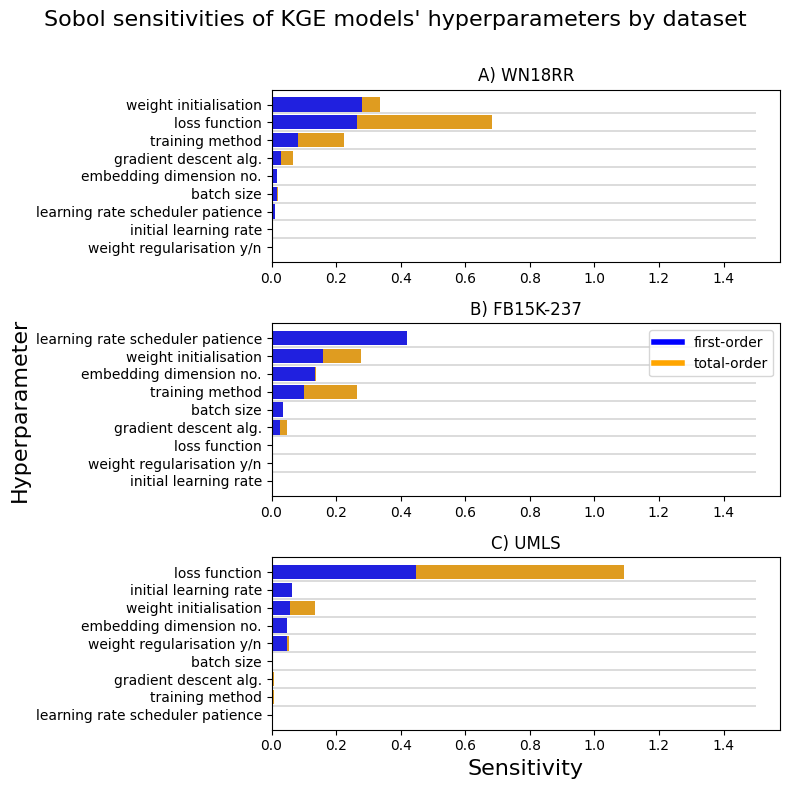

In [46]:
# Barplot for first/total order sensitivities
from string import ascii_uppercase
from matplotlib.lines import Line2D


plt.clf()
fig, axs = plt.subplots(3, figsize=(8, 8))
font_size = 16
total_order_colour = 'orange'
first_order_colour = 'blue'

for i, dataset in enumerate(['wn18rr', 'fb15k-237', 'umls']):
    # Plot total order sens first
    sensitivity_barplot(long_sens, dataset, axs[i], label=ascii_uppercase[i], group_dummies=True, label_size=font_size, which_index='total-order', colour=total_order_colour)
    # Plot first order sens overtop
    sensitivity_barplot(long_sens, dataset, axs[i], label=ascii_uppercase[i], group_dummies=True, label_size=font_size, which_index='first-order', colour=first_order_colour)

# Create custom legend
custom_lines = [Line2D([0], [0], color=first_order_colour, lw=4),
        Line2D([0], [0], color=total_order_colour, lw=4)]
axs[1].legend(custom_lines, ['first-order', 'total-order'])

plt.subplots_adjust(hspace=0.5)
plt.suptitle("Sobol sensitivities of KGE models' hyperparameters by dataset\n", fontsize=font_size)
plt.tight_layout()
plt.savefig(f'../../../paper/figures/sens_bar_plot.png')
plt.show(fig)

In [8]:
# Peform Spearman's rank on first order sens
from itertools import combinations
from scipy.stats import spearmanr

grouped_sens = {}
for dataset in long_sens.dataset.unique():
    grouped_sens[dataset] = group_dummies_func(long_sens, dataset)
    grouped_sens[dataset] = grouped_sens[dataset].loc[grouped_sens[dataset].index_type == 'first order'].reset_index(drop=True)

dataset_pairs = list(combinations(long_sens.dataset.unique(), 2))
for dataset_a, dataset_b in dataset_pairs:
    ranks_a = grouped_sens[dataset_a].loc[grouped_sens[dataset_a].dataset == dataset_a].sort_values('value', ascending=False).parameter
    ranks_b = grouped_sens[dataset_b].loc[grouped_sens[dataset_b].dataset == dataset_b].sort_values('value', ascending=False).parameter
    rank_cor = spearmanr(ranks_a, ranks_b)

    print(f'{dataset_a}-{dataset_b}: first-order correlation = {rank_cor.correlation}')

AttributeError: 'DataFrame' object has no attribute 'index_type'

In [59]:
import networkx as nx

def make_graph(sensitivities, interaction_matrix, connect_non_interactors=False):

    str_dict = {
        True: 'first-order < total-order',
        False: 'first-order = total-order'
    }

    # Generate graph
    G = nx.Graph()
    G.add_nodes_from(sensitivities.parameter, 
        s1_value=sensitivities.s1_value.values,
        param_interaction=[str_dict[bool] for bool in sensitivities.possible_interaction]
    )

    # Popuplate edges
    interactors = sensitivities.loc[sensitivities.possible_interaction].values
    for _, row in sensitivities.iterrows():
        if row.possible_interaction:
            head_node = row.parameter
            interaction_series = interaction_matrix[row.parameter]
            for val, index_param in zip(interaction_series, interaction_series.index):
                check1 = connect_non_interactors or index_param in interactors
                check2 = index_param != head_node
                check3 = index_param.split(':')[0] != head_node.split(':')[0]
                if all((check1, check2, check3)):
                    G.add_edge(head_node, index_param, weight=max(val, 0))

    return G

In [58]:
def plot_interactions(nx_graph, sensitivies_df, ax, label):
    from matplotlib.lines import Line2D
    from sklearn.preprocessing import MinMaxScaler

    # Compute positions for viz
    pos = nx.kamada_kawai_layout(nx_graph)

    # Get edge weights and alphas
    attributes = nx.get_edge_attributes(nx_graph, 'weight')
    weights = [attributes[key]*100 for key in attributes]
    alphas = [_[0] for _ in MinMaxScaler((0, 1)).fit_transform(np.array(weights).reshape(-1, 1))]

    # Get node colours (and legend)
    colour_dict = {
        True: 'red',
        False: 'lightblue'
    }
    colours = [colour_dict[bool] for bool in sensitivies_df.possible_interaction]

    # Draw networkx
    nx.draw_networkx_nodes(nx_graph, pos,
        node_size=sensitivies_df.s1_value*10000, 
        node_color=colours,
        ax=ax,
    )
    nx.draw_networkx_edges(nx_graph, pos,
        width=weights,
        alpha=alphas,
        ax=ax,
    )
    nx.draw_networkx_labels(nx_graph, pos, ax=ax, font_size=7)

    # Add additional plot features
    ax.set_title(f'{label}) {dataset.upper()}')
    #plt.suptitle('(1st order = node size, 2nd order = edge weight/alpha)', font_size='medium')

    if label == 'B':
        ax.legend(
            [Line2D(range(1), range(1), color="white", marker='o', markerfacecolor=colour_dict[boolean]) for boolean in colour_dict],
            ['total-order > first-order', 'total-order = first-order'], 
            loc='upper left'
        )

    return fig

/Users/fu19841/miniconda3/envs/libkge/lib/python3.7/site-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
/Users/fu19841/miniconda3/envs/libkge/lib/python3.7/site-packages/networkx/drawing/layout.py:727: RuntimeWarning: divide by zero encountered in true_divide
  costargs = (np, 1 / (dist_mtx + np.eye(dist_mtx.shape[0]) * 1e-3), meanwt, dim)
/Users/fu19841/miniconda3/envs/libkge/lib/python3.7/site-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#return

<Figure size 640x480 with 0 Axes>

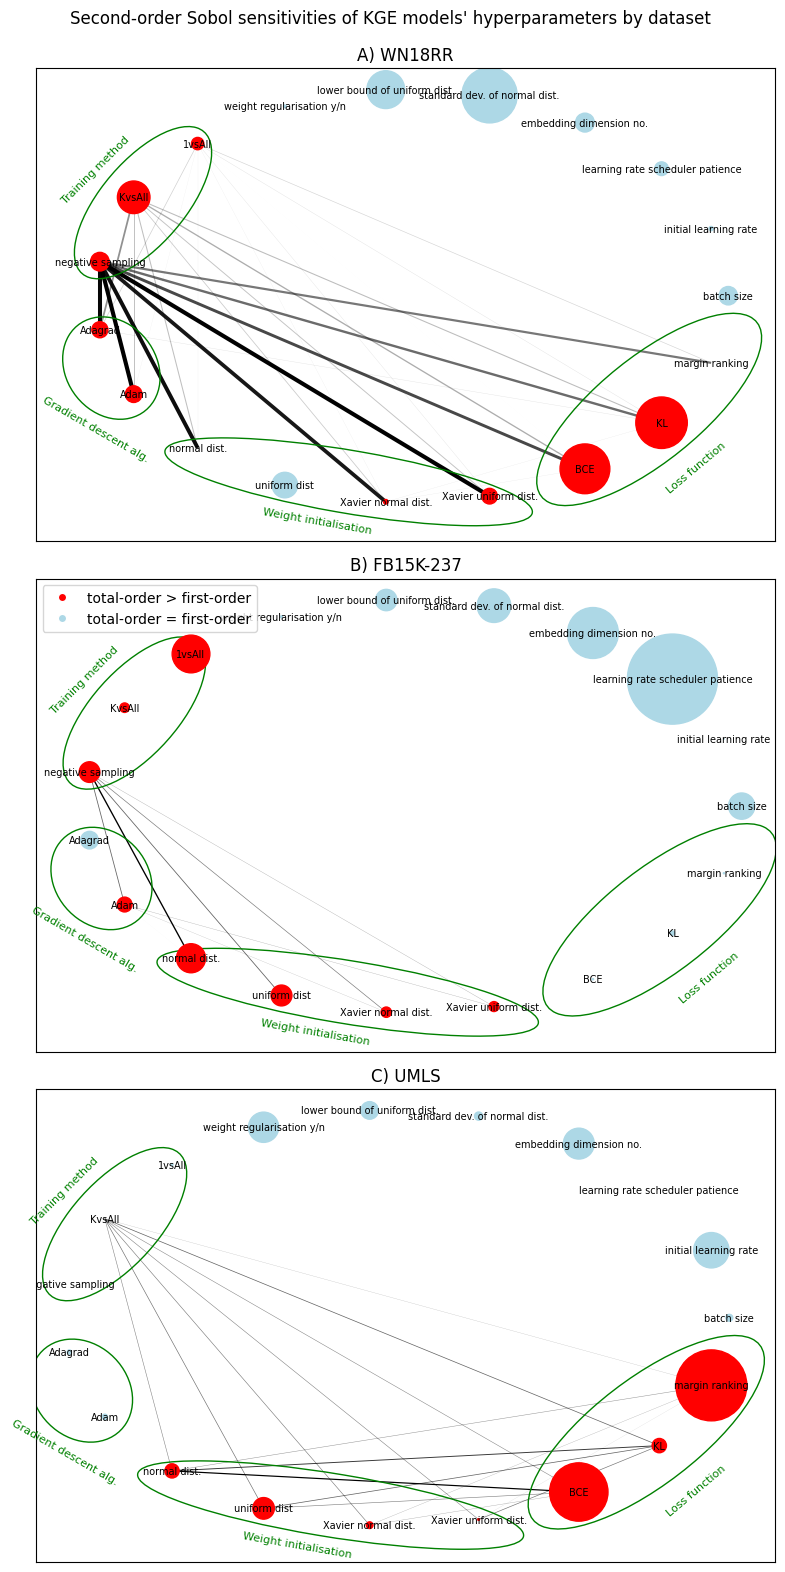

In [106]:
from matplotlib.patches import Ellipse

# Create interaction plots and save
plt.clf()
fig, axs = plt.subplots(3, figsize=(8, 16))

for i, dataset in enumerate(['wn18rr', 'fb15k-237', 'umls']):
    df = sens_results.loc[sens_results.dataset == dataset]
    df.parameter = [label.split(': ')[1] if ':' in label else label for label in df.parameter]
    net = make_graph(df, interactions[dataset]['values'], connect_non_interactors=False)
    plot_interactions(net, df, axs[i], label=ascii_uppercase[i])

# Add decorations
plt.suptitle("Second-order Sobol sensitivities of KGE models' hyperparameters by dataset\n")

# Draw bands round groups of dummies
colour = 'green'
for ax in axs:
    # Training method
    ax.add_patch(Ellipse((-0.85, 0.45), 0.8, 0.3, angle=65, linewidth=1, fill=False, color=colour))
    ax.text(-1, 0.45, "Training method", size=8, rotation=45, ha="center", color="g")

    # Grad descent
    ax.add_patch(Ellipse((-0.95, -0.35), 0.5, 0.3, angle=-80, linewidth=1, fill=False, color=colour))
    ax.text(-1, -0.8, "Gradient descent alg.", size=8, rotation=-30, ha="center", color="g")

    # Weight init (bottom)
    ax.add_patch(Ellipse((-0.2, -0.9), 1.2, 0.3, angle=-15, linewidth=1, fill=False, color=colour))
    ax.text(-0.3, -1.15, "Weight initialisation", size=8, rotation=-10, ha="center", color="g")

    # Loss func
    ax.add_patch(Ellipse((0.75, -0.55), 1.1, 0.4, angle=55, linewidth=1, fill=False, color=colour))
    ax.text(0.9, -0.95, "Loss function", size=8, rotation=40, ha="center", color="g")

plt.tight_layout()

# Save
plt.savefig(f'../../../paper/figures/interaction_networks.png')
plt.show(fig)

In [26]:
np.array([[1], [2]]).flatten()

array([1, 2])

In [43]:
# Get Pearsons corr for flattened upper triangles of adj matrices
from numpy import triu, isnan
from scipy.stats import pearsonr

flat_triangles = {}
for dataset in long_sens.dataset.unique():
    adj_matrix = interactions[dataset]['values'].to_numpy()
    upper = triu(adj_matrix).flatten()
    flat_triangles[dataset] = [val for val in upper if val != 0 and not isnan(val)]

for dataset_a, dataset_b in dataset_pairs:
    corr = pearsonr(flat_triangles[dataset_a], flat_triangles[dataset_b])
    print(f'{dataset_a}-{dataset_b}: second-order correlation = {corr[0]}')


umls-wn18rr: second-order correlation = 0.5158335039566797
umls-fb15k-237: second-order correlation = 0.05042892331500735
wn18rr-fb15k-237: second-order correlation = 0.09249209724028541
